## Visualizing crime types in Chicago

In [90]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import json
from bokeh.io import show, output_notebook, output_file
from bokeh.models import (
    GeoJSONDataSource,
    HoverTool,
    CategoricalColorMapper,
    LinearColorMapper,
    ColumnDataSource,
    LogColorMapper,
    LogTicker,
    ColorBar
)

from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.palettes import Viridis6 as palette
from bokeh.palettes import RdYlGn11 as palette2
from bokeh.palettes import Viridis3 as palette3

mpl.rcParams['figure.figsize'] = (16,8)
mpl.style.use('ggplot')

In [3]:
def parse_date_month(d):
    parsed = d.split(" ")[0].split("/")
    return parsed[2]+ "-" + parsed[0]

In [4]:
df = pd.read_csv("../data/crimes_in_polygon.csv")
df = df[["ID", "Date", "Year", "Zip", "Location Description", "Primary Type", "Latitude","Longitude"]]
df["Month"] = df["Date"].apply(parse_date_month)
df["Month"] = pd.to_datetime(df["Month"])
df["Zip"] = df["Zip"].astype('category')

In [5]:
df_by_year = df.groupby("Year").count().ID

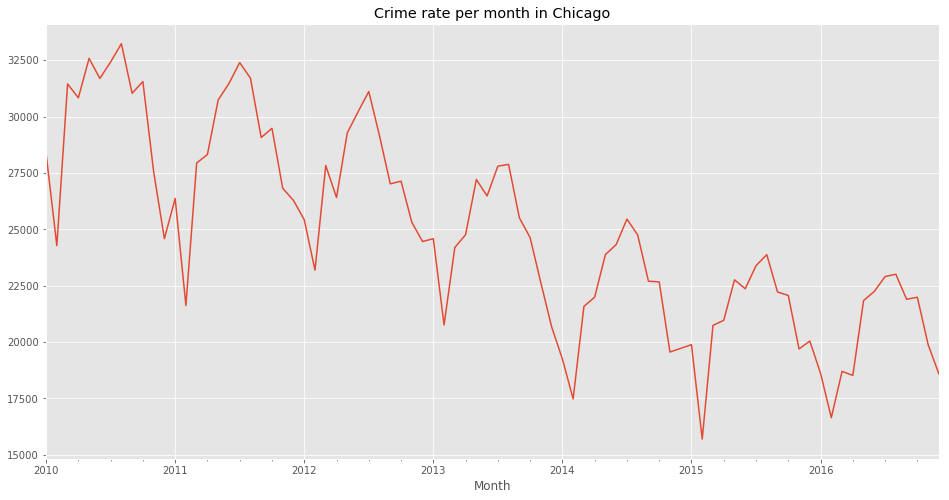

In [6]:
df_by_month = df.groupby("Month").count().ID
df_by_month.plot(title="Crime rate per month in Chicago");

Next we turn the crime types into categorical data and plot the results

In [7]:
df["Primary Type"] = df["Primary Type"].astype('category')
df["Primary Type"].unique()

[PUBLIC PEACE VIOLATION, NARCOTICS, BATTERY, CRIMINAL DAMAGE, WEAPONS VIOLATION, ..., NON-CRIMINAL, NON-CRIMINAL (SUBJECT SPECIFIED), NON - CRIMINAL, CONCEALED CARRY LICENSE VIOLATION, HUMAN TRAFFICKING]
Length: 33
Categories (33, object): [PUBLIC PEACE VIOLATION, NARCOTICS, BATTERY, CRIMINAL DAMAGE, ..., NON-CRIMINAL (SUBJECT SPECIFIED), NON - CRIMINAL, CONCEALED CARRY LICENSE VIOLATION, HUMAN TRAFFICKING]

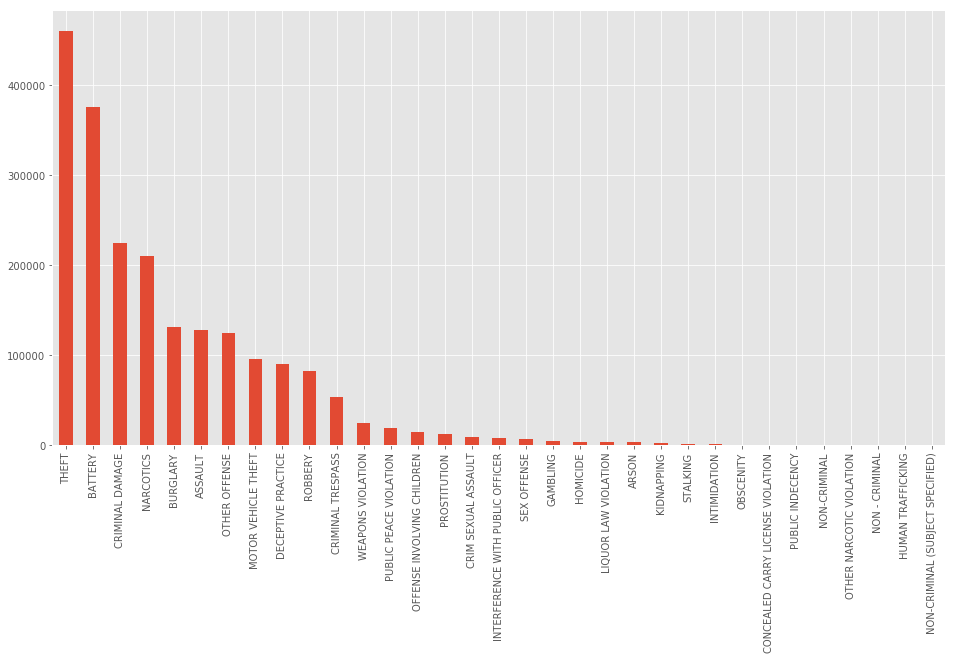

In [8]:
crime_type_dist = df["Primary Type"].value_counts()
crime_type_dist.plot(kind="bar")

In [9]:
#Create and sort crimedata
crime_type_by_year = pd.DataFrame({ "2010" : df[df.Year == 2010]["Primary Type"].value_counts(),
                               "2011" : df[df.Year == 2011]["Primary Type"].value_counts(),
                               "2012" : df[df.Year == 2012]["Primary Type"].value_counts(),
                               "2013" : df[df.Year == 2013]["Primary Type"].value_counts(),
                               "2014" : df[df.Year == 2014]["Primary Type"].value_counts(),
                               "2015" : df[df.Year == 2015]["Primary Type"].value_counts(),
                               "2016" : df[df.Year == 2016]["Primary Type"].value_counts(),
                               "Total" : df["Primary Type"].value_counts()})

crime_type_by_year = crime_type_by_year.sort_values(by="Total", ascending=False)
crime_type_by_year = crime_type_by_year.drop(['Total'], axis=1)

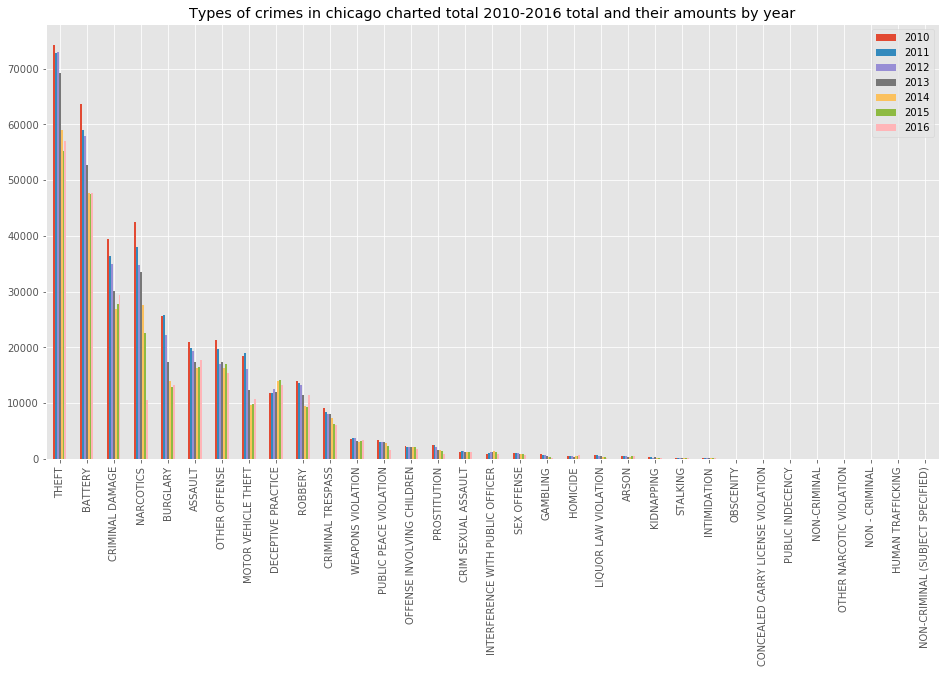

In [10]:
crime_type_by_year.plot(title="Types of crimes in chicago charted total 2010-2016 total and their amounts by year", kind="bar")

It's quite clear that in our dataset, most of the crimes involve 
either violence, some kind of targeting to others property or 
drug usage.

Next lets see what are the top 10 locations where most of the crimes are made

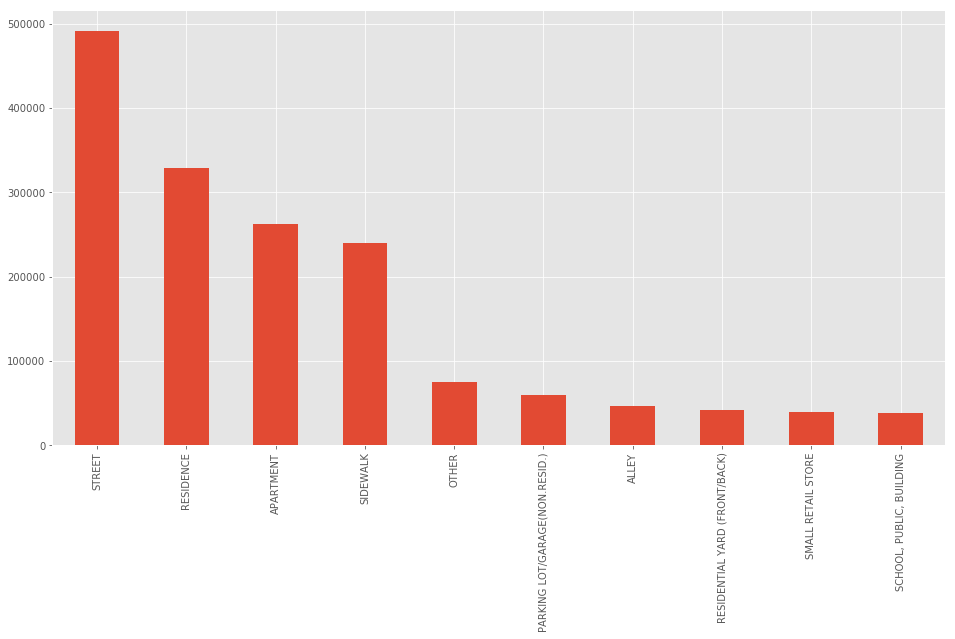

In [11]:
df["Location Description"].value_counts().head(10).plot(kind="bar")

In [12]:
#Remove spaces
df.rename(columns={'Month': 'Month', 'Location Description': 'Location', 'Primary Type': 'Type'}, inplace=True)

We should now check to see which location a crime is most likely to happen given a season.

To do this, we will first group the crimes by month and location, and then check the location where most crimes happened
that month.

In [13]:
df_location_by_month = df.groupby(['Month','Location'])['Location'].agg({'No':'count'})

mask_max = df_location_by_month.groupby(level=0).agg('idxmax')
mask_min = df_location_by_month.groupby(level=0).agg('idxmin')

df_count_max = df_location_by_month.loc[mask_max['No']]

df_count_min = df_location_by_month.loc[mask_min['No']]

G:\Programming\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [14]:
#Count the unique locations for the most crimes
print(df_count_max.groupby('Location')['No'].count())
print(df_count_min.groupby('Location')['No'].count())

Location
STREET    84
Name: No, dtype: int64
Location
AIRCRAFT                                            4
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA     1
AIRPORT BUILDING NON-TERMINAL - SECURE AREA         2
AIRPORT EXTERIOR - NON-SECURE AREA                  7
AIRPORT EXTERIOR - SECURE AREA                     17
AIRPORT PARKING LOT                                 2
AIRPORT TERMINAL LOWER LEVEL - SECURE AREA          3
AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA       17
AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA      4
AIRPORT TRANSPORTATION SYSTEM (ATS)                 8
AIRPORT VENDING ESTABLISHMENT                       2
AIRPORT/AIRCRAFT                                    1
AUTO                                                2
BOWLING ALLEY                                       4
BRIDGE                                              3
CEMETARY                                            1
CHA PARKING LOT                                     1
CLEANERS/LAUNDROMAT         

From the above we can see that regardless of season, the crimes committed in the Street -location
are always the most prevalent, while the minimum amount of crimes per month have often been in the Airport.

Oddly, the minimum amount of reported crimes per location has been only 1 every single month. (could be an oversight from me)



In [15]:
print("Maximum of most crimes per month in a location(Street):",df_count_max.max())
print("Minimum of most crimes per month in a location(Street):",df_count_max.min())

print("Maximum of least crimes per month in a location:",df_count_min.max())
print("Minimum of least crimes per month in a location:",df_count_min.min())

Maximum of most crimes per month in a location(Street): No    8555
dtype: int64
Minimum of most crimes per month in a location(Street): No    3768
dtype: int64
Maximum of least crimes per month in a location: No    1
dtype: int64
Minimum of least crimes per month in a location: No    1
dtype: int64


The following is an illustration according to the months, on how the Street -crimes fluctuate between the months.

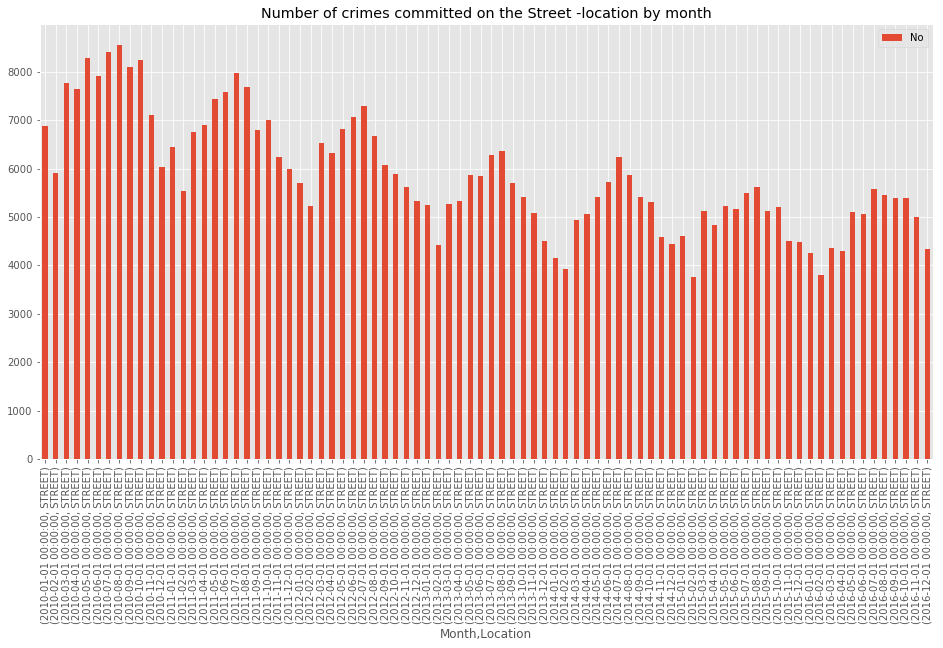

In [16]:
df_count_max.plot.bar(title="Number of crimes committed on the Street -location by month")

Next, we'll look at how the types and locations of crime fall into the different zip-codes.

In [161]:
crime_types_by_zip = df.groupby("Zip")["Type"].agg(lambda x:x.value_counts().index[0])
crime_types_by_zip.index = crime_types_by_zip.index.astype("str")
crime_types_by_zip = crime_types_by_zip.to_dict()

In [18]:
crime_location_by_zip = df.groupby("Zip")["Location"].agg(lambda x:x.value_counts().index[0])
crime_location_by_zip.index = crime_location_by_zip.index.astype("str")
crime_location_by_zip = crime_location_by_zip.to_dict()

In [125]:
crimes_by_zip = df.groupby("Zip").size()
crimes_by_zip.index = crimes_by_zip.index.astype("str")
total_crimes = crimes_by_zip.sum() 
crimes_by_zip = crimes_by_zip\
                            .div(total_crimes)\
                            .multiply(100)\
                            .round(2)\
                            .to_dict()

In [56]:
output_notebook()

color_mapper = LogColorMapper(palette=palette2,
                                 low=min(crimes_by_zip.values()),
                                 high=max(crimes_by_zip.values()))

with open(r'../map/zip/zip_codes.geojson', 'r') as f:
    geojson = json.loads(f.read())
    # append aggregated crime counts
    for i in range(len(geojson["features"])):
        di = geojson["features"][i]
        di_id = di["properties"]["zip"]
        if di_id in crimes_by_zip:
            di["properties"]["crime_rate"] = crimes_by_zip[di_id]
            di["properties"]["crime_type"] = crime_types_by_zip[di_id]
            di["properties"]["crime_location"] = crime_location_by_zip[di_id]
        else:
            di["properties"]["crime_rate"] = "None"
            di["properties"]["crime_type"] = "None"
            di["properties"]["crime_location"] = "None"
    geojson = json.dumps(geojson)
    geo_source = GeoJSONDataSource(geojson=geojson)
    
hover = HoverTool(tooltips=[
    ("zip", "@zip"),
    ("crime_rate", "@crime_rate%"),
    ("crime_type", "@crime_type"),
    ("crime_location", "@crime_location")
])

psource = ColumnDataSource(df[["Latitude", "Longitude"]].sample(10000))

color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0),
                    major_label_text_font_size='10pt')

p1 = figure(title="Chicago crime%, types and location per ZIP", 
           tools=[hover, "pan,wheel_zoom,box_zoom,reset"], 
           x_axis_location=None, 
           y_axis_location=None,
           toolbar_location=None)

p1.grid.grid_line_color = None

p1.patches('xs', 'ys', 
          line_color='black', 
          fill_color={'field': 'crime_rate', 'transform': color_mapper},
          line_width=1, 
          source=geo_source)

p1.add_layout(color_bar, 'right')

Loading BokehJS ...

In [43]:
show(p1)

In [244]:
output_notebook()

color_mapper = CategoricalColorMapper(factors=["THEFT","BATTERY","NARCOTICS"],palette=["red","green","blue"])

with open(r'../map/zip/zip_codes.geojson', 'r') as f:
    geojson = json.loads(f.read())
    # append aggregated crime counts
    for i in range(len(geojson["features"])):
        di = geojson["features"][i]
        di_id = di["properties"]["zip"]
        if di_id in crimes_by_zip:
            di["properties"]["crime_type"] = crime_types_by_zip[di_id]
        else:
            di["properties"]["crime_type"] = "None"
    geojson = json.dumps(geojson)
    geo_source = GeoJSONDataSource(geojson=geojson)
    
hover = HoverTool(tooltips=[
    ("zip", "@zip"),
    ("crime_type", "@crime_type")
])

psource = ColumnDataSource(df[["Latitude", "Longitude"]].sample(10000))
'''
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0),
                    major_label_text_font_size='10pt')
'''
p1 = figure(title="Chicago crime types per ZIP (Red = Theft, Blue = Narcotics, Green = Battery)", 
           tools=[hover, "pan,wheel_zoom,box_zoom,reset"], 
           x_axis_location=None, 
           y_axis_location=None,
           toolbar_location=None)

p1.grid.grid_line_color = None

p1.patches('xs', 'ys', 
          line_color='black', 
          fill_color={'field': 'crime_type', 'transform': color_mapper},
          line_width=1, 
          source=geo_source)

p1.patch('xs', 'ys', legend="Theft", fill_color="red", source=geo_source)
p1.patch('xs', 'ys', legend="Battery", fill_color="green", source=geo_source)
p1.patch('xs', 'ys', legend="Narcotics", fill_color="blue", source=geo_source)

Loading BokehJS ...

GlyphRenderer(id='8eda9320-3f59-4cb3-bc57-cdf3292765a4', ...)

In [245]:
show(p1)

In [246]:
output_notebook()

color_mapper = CategoricalColorMapper(factors=["STREET","RESIDENCE","RESTAURANT","APARTMENT","DEPARTMENT STORE"],palette=["blue","red","green","yellow","orange"])

with open(r'../map/zip/zip_codes.geojson', 'r') as f:
    geojson = json.loads(f.read())
    # append aggregated crime counts
    for i in range(len(geojson["features"])):
        di = geojson["features"][i]
        di_id = di["properties"]["zip"]
        if di_id in crimes_by_zip:
            di["properties"]["crime_location"] = crime_location_by_zip[di_id]
        else:
            di["properties"]["crime_location"] = "None"
    geojson = json.dumps(geojson)
    geo_source = GeoJSONDataSource(geojson=geojson)
    
hover = HoverTool(tooltips=[
    ("zip", "@zip"),
    ("crime_location", "@crime_location")
])

psource = ColumnDataSource(df[["Latitude", "Longitude"]].sample(10000))
'''
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0),
                    major_label_text_font_size='10pt')
'''
p1 = figure(title="Chicago crime locations per ZIP", 
           tools=[hover, "pan,wheel_zoom,box_zoom,reset"], 
           x_axis_location=None, 
           y_axis_location=None,
           toolbar_location=None)

p1.grid.grid_line_color = None

p1.patches('xs', 'ys', 
          line_color='black', 
          fill_color={'field': 'crime_location', 'transform': color_mapper},
          line_width=1, 
          source=geo_source)

p1.patch('xs', 'ys', legend="Street", fill_color="blue", source=geo_source)
p1.patch('xs', 'ys', legend="Residence", fill_color="red", source=geo_source)
p1.patch('xs', 'ys', legend="Restaurant", fill_color="green", source=geo_source)
p1.patch('xs', 'ys', legend="Apartment", fill_color="yellow", source=geo_source)
p1.patch('xs', 'ys', legend="Department Store", fill_color="orange", source=geo_source)

Loading BokehJS ...

GlyphRenderer(id='13205828-c2d0-4553-9f8f-1d13e740dcef', ...)

In [247]:
show(p1)